# Определение перспективного тарифа для телеком компании

## Введение

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Краткий план: 
---
- Шаг 1. Открыть файл с данными и изучить общую информацию.
- Шаг 2. Подготовить данные. Найти и исправить ошибки.
- Шаг 3. Описать поведение клиентов оператора, исходя из выборки. Рассчитать, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.
- Шаг 4. Проверить две гипотезы относительно данных.
- Шаг 5. Сделать обший вывод.


Описание данных:
---
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана
--- 
Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок
---
Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение
---
Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя
- Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Ознакомление с данными

#### Подключаем необходимые для предобработки и анализа библиотеки

In [49]:
import pandas as pd # для работы с DataFrame
import numpy as np # для работы с масссивами
import math # для математических операций
import datetime # для работы с датами
from matplotlib import pyplot as plt # для построения диаграмм и графиков
import scipy # для использования статистических инструментов

#### Проводим первичный анализ поступивших данных

In [50]:
df_calls = pd.read_csv('/datasets/calls.csv') # анализируем звонки
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [51]:
df_internet = pd.read_csv('/datasets/internet.csv') # анализируем интернет
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [52]:
df_messages = pd.read_csv('/datasets/messages.csv') # анализируем сообщения
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [53]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv') # анализируем тарифы
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [54]:
df_users = pd.read_csv('/datasets/users.csv') # анализируем пользователей
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


После поверхностного анализа были замечены следующие особенности: в таблице звонков присутствуют нулевые звонки, в таблице пользователей 38 человек завершили пользование тарифами. Поскольку компании важны текущие пользователи (и неизвестно, когда эти 38 человек прекратили пользоваться), то для дальнейшего анализа они не нужны. В любом случае, надо сделать предобработку данных, поэтому приступим.

# Предобработка данных

In [55]:
print(df_calls.isnull().sum()) # считаем пропущенные значения для звонков
print('Количество дубликатов:', df_calls.duplicated().sum()) # считаем дубликаты для звонков
df_calls.drop(df_calls[df_calls.duration == 0.0].index, inplace=True) # удаляем нулевые звонки
df_calls['duration'] = np.ceil(df_calls['duration']) # округляем в большую сторону

id           0
call_date    0
duration     0
user_id      0
dtype: int64
Количество дубликатов: 0


In [56]:
print(df_messages.isnull().sum()) # считаем пропущенные значения для сообщений
print('Количество дубликатов:', df_messages.duplicated().sum()) # считаем дубликаты для сообщений

id              0
message_date    0
user_id         0
dtype: int64
Количество дубликатов: 0


In [57]:
print(df_internet.isnull().sum()) # считаем пропущенные значения для интернета
print('Количество дубликатов:', df_internet.duplicated().sum()) # считаем дубликаты для интернета
df_internet['mb_used'] = np.ceil(df_internet['mb_used']) # округляем в большую сторону

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64
Количество дубликатов: 0


In [58]:
print(df_tariffs.isnull().sum()) # считаем пропущенные значения для трафика
print('Количество дубликатов:', df_tariffs.duplicated().sum()) # считаем дубликаты для трафика

messages_included        0
mg_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
tariff_name              0
dtype: int64
Количество дубликатов: 0


In [59]:
print(df_users.isnull().sum()) # считаем пропущенные значения для пользователей
print('Количество дубликатов:', df_users.duplicated().sum()) # считаем дубликаты для пользователей
df_users = df_users[pd.isnull(df_users['churn_date'])] # удаляем пользователей
df_users.info() # проверка, что удалили ненужных пользователей

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64
Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 462 entries, 0 to 499
Data columns (total 8 columns):
user_id       462 non-null int64
age           462 non-null int64
churn_date    0 non-null object
city          462 non-null object
first_name    462 non-null object
last_name     462 non-null object
reg_date      462 non-null object
tariff        462 non-null object
dtypes: int64(2), object(6)
memory usage: 32.5+ KB


In [60]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month # добавляем столбец с месяцами

In [61]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month # добавляем столбец с месяцами

In [62]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month # добавляем столбец с месяцами

In [63]:
num_calls = df_calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']) # подсчет количества звонков
num_messages = df_messages.groupby(['user_id', 'month'])['id'].count() # подсчет количества смс
num_internet = df_internet.groupby(['user_id', 'month']).sum()['mb_used'] # подсчет трафика

In [64]:
df_event_numbers = pd.concat([num_calls, num_messages, num_internet], axis=1) # добавляем новые столбцы
df_event_numbers = df_event_numbers.reset_index()
df_event_numbers.rename(columns={'id': 'sms'}, inplace=True)
df_event_numbers.head()

,user_id,month,count,sum,sms,mb_used
0,1000,5,17.0,159.0,22.0,2256.0
1,1000,6,28.0,172.0,60.0,23257.0
2,1000,7,41.0,340.0,75.0,14016.0
3,1000,8,42.0,408.0,81.0,14070.0
4,1000,9,46.0,466.0,57.0,14581.0


In [65]:
df_all_information = pd.merge(df_event_numbers, df_users.loc[:, ['tariff', 'city', 'age', 'user_id']], on='user_id') # создание сводной таблицы

In [66]:
def minutes (raw): # функция для рассчета превышения минут
    if raw['tariff'] == 'smart':
        if raw['sum'] - 500 > 0:
            return (raw['sum'] - 500)*3
        return 0
    else:
        if raw['sum'] - 3000 > 0:
            return (raw['sum'] - 3000)*1
        return 0

In [67]:
def messages (raw): # функция для рассчета превышения сообщений
    if raw['tariff'] == 'smart':
        if raw['sms'] - 50 > 0:
            return (raw['sms'] - 50)*3
        return 0
    else:
        if raw['sms'] - 1000 > 0:
            return (raw['sms'] - 1000)*1
        return 0

In [68]:
def trafic (raw): # функция для рассчета превышения трафика 
    if raw['tariff'] == 'smart':
        if raw['mb_used']/1024 - 15 > 0:
            return (raw['mb_used']/1024 - 15)*200
        return 0
    else:
        if raw['mb_used']/1024 - 30 > 0:
            return (raw['mb_used']/1024 - 30)*150
        return 0

In [69]:
def tariff_pay (raw): # функция для стоимости тарифа
    if raw['tariff'] == 'smart':
        return 550
    return 1950

In [70]:
df_all_information['minutes_up_rub'] = df_all_information.apply(minutes, axis=1) # считаем превышение минут
df_all_information['messages_up_rub'] = df_all_information.apply(messages, axis=1) #  считаем превышение сообщений
df_all_information['trafic_up_rub'] = df_all_information.apply(trafic, axis=1) # считаем превышение трафика
df_all_information['trafic_up_rub'] = np.ceil(df_all_information['trafic_up_rub'])
df_all_information['tariff_pay'] = df_all_information.apply(tariff_pay, axis=1) # определяем цену тарифа
df_all_information['total_income'] = (df_all_information['minutes_up_rub'] + df_all_information['messages_up_rub'] + df_all_information['trafic_up_rub'] + df_all_information['tariff_pay']).astype('int') # считаем суммарный доход

In [71]:
df_all_information.head(10) # смотрим, что получилось

,user_id,month,count,sum,sms,mb_used,tariff,city,age,minutes_up_rub,messages_up_rub,trafic_up_rub,tariff_pay,total_income
0,1000,5,17.0,159.0,22.0,2256.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
1,1000,6,28.0,172.0,60.0,23257.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
2,1000,7,41.0,340.0,75.0,14016.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
3,1000,8,42.0,408.0,81.0,14070.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
4,1000,9,46.0,466.0,57.0,14581.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
5,1000,10,44.0,350.0,73.0,14717.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
6,1000,11,37.0,338.0,58.0,14768.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
7,1000,12,38.0,333.0,70.0,9827.0,ultra,Краснодар,52,0.0,0.0,0.0,1950,1950
8,1001,11,45.0,430.0,NaN,18452.0,smart,Москва,41,0.0,0.0,604.0,550,1154
9,1001,12,47.0,414.0,NaN,14053.0,smart,Москва,41,0.0,0.0,0.0,550,550


Итак, предобработка данных завершена. Удалены события с нулевыми звонками и пользователи, которые перестали пользоваться тарифами. Преобразованы данные с учетом округления в большую сторону. Составлена сводная таблица по каждому пользователю с посчитанными превышениями по звонкам, сообщениям и интернету. Пора приступать к анализу!

# Анализ данных

Text(0.5, 0, 'Минуты')

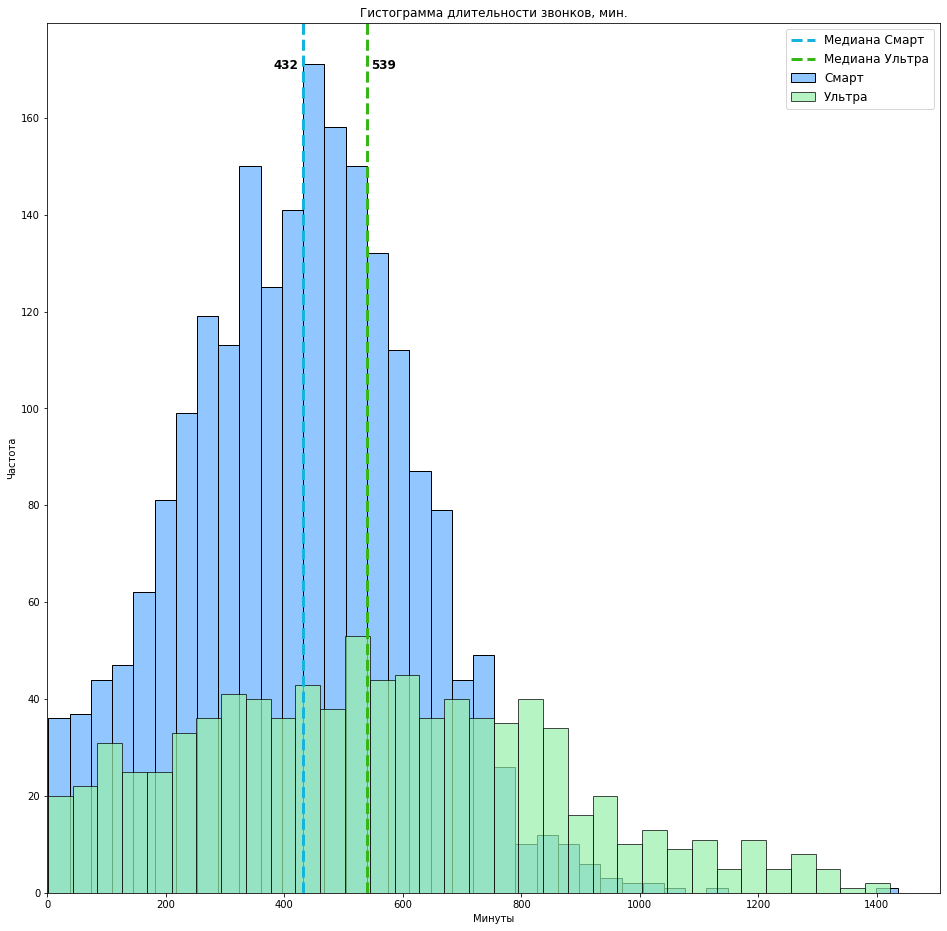

In [72]:
ax = plt.gca() # создаем пустой график
column = 'sum' # данные какого столбца будем рисовать
title = 'Гистограмма длительности звонков, мин.' # заголовок
df_all_information[df_all_information['tariff'] == 'smart'][column].plot(kind='hist', bins=40, figsize=(16,16), 
                                                                    ec='black', ax=ax, color='#92c6ff', 
                                                                    title=title, xlim=0) # рисуем 1-й график
df_all_information[df_all_information['tariff'] == 'ultra'][column].plot(kind='hist', bins=40, figsize=(16,16), 
                                                                    ec='black', ax=ax, color='#97F0AA', 
                                                                    title=title, xlim=0, alpha=0.7) # рисуем 2-й график 
plt.axvline(x=df_all_information[df_all_information['tariff'] == 'smart'][column].median(),
            linewidth=3, color='#16B4DC', linestyle='--') # рисуем медианы (сама линия, потом подпись)
ax.text(df_all_information[df_all_information['tariff'] == 'smart'][column].median()-50, 170, 
        '{0:.0f}'.format(df_all_information[df_all_information['tariff'] == 'smart'][column].median()), 
        fontweight='bold', fontsize='large')
plt.axvline(x=df_all_information[df_all_information['tariff'] == 'ultra'][column].median(),
            linewidth=3, color='#35B815', linestyle='--') # рисуем медианы (сама линия, потом подпись)
ax.text(df_all_information[df_all_information['tariff'] == 'ultra'][column].median()+7, 170, 
        '{0:.0f}'.format(df_all_information[df_all_information['tariff'] == 'ultra'][column].median()), 
        fontweight='bold', fontsize='large')
plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12}) # рисуем легенду (содержание и размер шрифта)
ax.set_ylabel('Частота')
ax.set_xlabel('Минуты')

In [73]:
column = 'sum'
variance = np.var(df_all_information[df_all_information['tariff'] == 'smart'][column], ddof=1) # считаем дисперсию
standard_deviation = np.std(df_all_information[df_all_information['tariff'] == 'smart'][column], ddof=1) # считаем стандартное отклоение
print ('Среднее значение тарифа смарт равно:', df_all_information[df_all_information['tariff'] == 'smart'][column].mean().astype('int')) # считаем среднее
print ('Стандартное отклонение тарифа смарт равно:', standard_deviation.astype('int')) 
print ('Дисперсия тарифа смарт равна:', variance.astype('int'))
print()
variance = np.var(df_all_information[df_all_information['tariff'] == 'ultra'][column], ddof=1) # считаем дисперсию
standard_deviation = np.std(df_all_information[df_all_information['tariff'] == 'ultra'][column], ddof=1) # считаем стандартное отклоение
print ('Среднее значение тарифа ультра равно:', df_all_information[df_all_information['tariff'] == 'ultra'][column].mean().astype('int')) # считаем среднее
print ('Стандартное отклонение тарифа ультра равно:', standard_deviation.astype('int')) 
print ('Дисперсия тарифа ультра равна:', variance.astype('int'))

Среднее значение тарифа смарт равно: 424
Стандартное отклонение тарифа смарт равно: 189
Дисперсия тарифа смарт равна: 36017

Среднее значение тарифа ультра равно: 555
Стандартное отклонение тарифа ультра равно: 307
Дисперсия тарифа ультра равна: 94290


Text(0.5, 0, 'Количество сообщений')

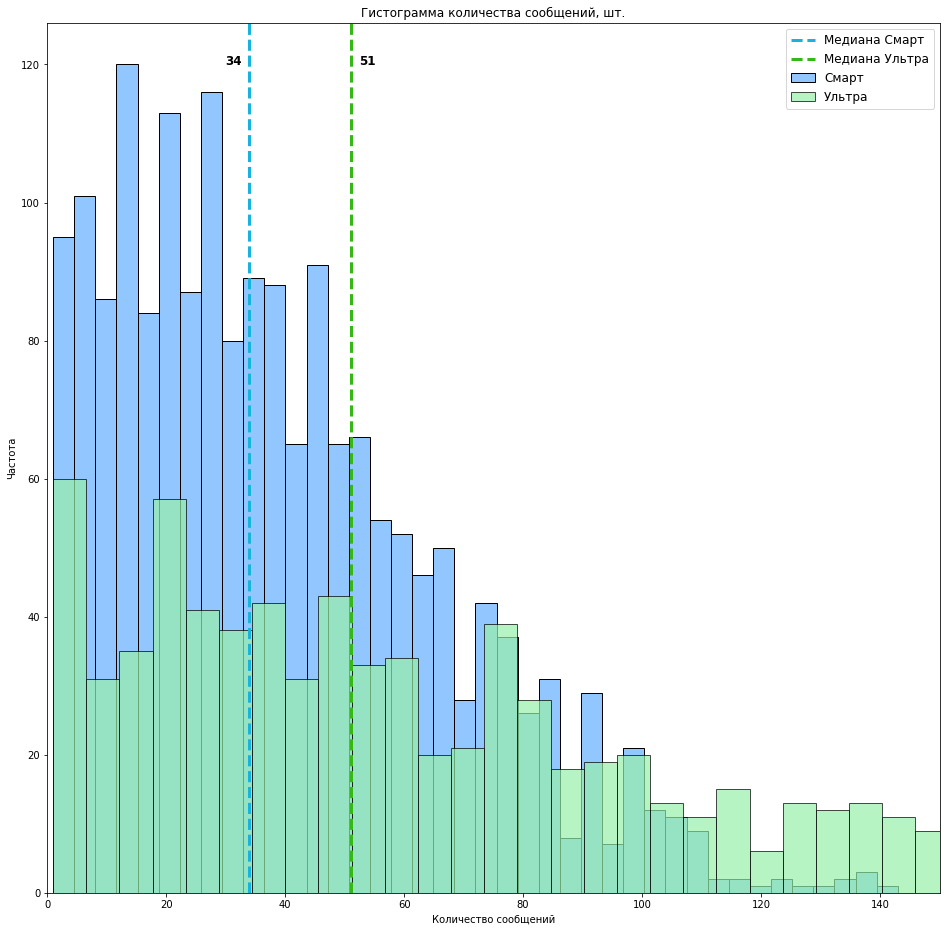

In [74]:
ax = plt.gca() # создаем пустой график
column = 'sms' # данные какого столбца будем рисовать
title = 'Гистограмма количества сообщений, шт.' # заголовок
df_all_information[df_all_information['tariff'] == 'smart'][column].plot(kind='hist', bins=40, figsize=(16,16), 
                                                                    ec='black', ax=ax, color='#92c6ff', 
                                                                    title=title, xlim=0) # рисуем 1-й график
df_all_information[df_all_information['tariff'] == 'ultra'][column].plot(kind='hist', bins=40, figsize=(16,16), 
                                                                    ec='black', ax=ax, color='#97F0AA', 
                                                                    title=title, xlim=0, alpha=0.7) # рисуем 2-й график 
plt.axvline(x=df_all_information[df_all_information['tariff'] == 'smart'][column].median(),
            linewidth=3, color='#16B4DC', linestyle='--') # рисуем медианы (сама линия, потом подпись)
ax.text(df_all_information[df_all_information['tariff'] == 'smart'][column].median()-4, 120, 
        '{0:.0f}'.format(df_all_information[df_all_information['tariff'] == 'smart'][column].median()), 
        fontweight='bold', fontsize='large')
plt.axvline(x=df_all_information[df_all_information['tariff'] == 'ultra'][column].median(),
            linewidth=3, color='#35B815', linestyle='--') # рисуем медианы (сама линия, потом подпись)
ax.text(df_all_information[df_all_information['tariff'] == 'ultra'][column].median()+1.5, 120, 
        '{0:.0f}'.format(df_all_information[df_all_information['tariff'] == 'ultra'][column].median()), 
        fontweight='bold', fontsize='large')
plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12}) # рисуем легенду (содержание и размер шрифта)
ax.set_ylabel('Частота') 
ax.set_xlabel('Количество сообщений')

In [75]:
column = 'sms'
variance = np.var(df_all_information[df_all_information['tariff'] == 'smart'][column], ddof=1) # считаем дисперсию
standard_deviation = np.std(df_all_information[df_all_information['tariff'] == 'smart'][column], ddof=1) # считаем стандартное отклоение
print ('Среднее значение тарифа смарт равно:', df_all_information[df_all_information['tariff'] == 'smart'][column].mean().astype('int')) # считаем среднее
print ('Стандартное отклонение тарифа смарт равно:', standard_deviation.astype('int')) 
print ('Дисперсия тарифа смарт равна:', variance.astype('int'))
print()
variance = np.var(df_all_information[df_all_information['tariff'] == 'ultra'][column], ddof=1) # считаем дисперсию
standard_deviation = np.std(df_all_information[df_all_information['tariff'] == 'ultra'][column], ddof=1) # считаем стандартное отклоение
print ('Среднее значение тарифа ультра равно:', df_all_information[df_all_information['tariff'] == 'ultra'][column].mean().astype('int')) # считаем среднее
print ('Стандартное отклонение тарифа ультра равно:', standard_deviation.astype('int')) 
print ('Дисперсия тарифа ультра равна:', variance.astype('int'))

Среднее значение тарифа смарт равно: 39
Стандартное отклонение тарифа смарт равно: 26
Дисперсия тарифа смарт равна: 728

Среднее значение тарифа ультра равно: 61
Стандартное отклонение тарифа ультра равно: 46
Дисперсия тарифа ультра равна: 2165


Text(0.5, 0, 'Суммарный трафик')

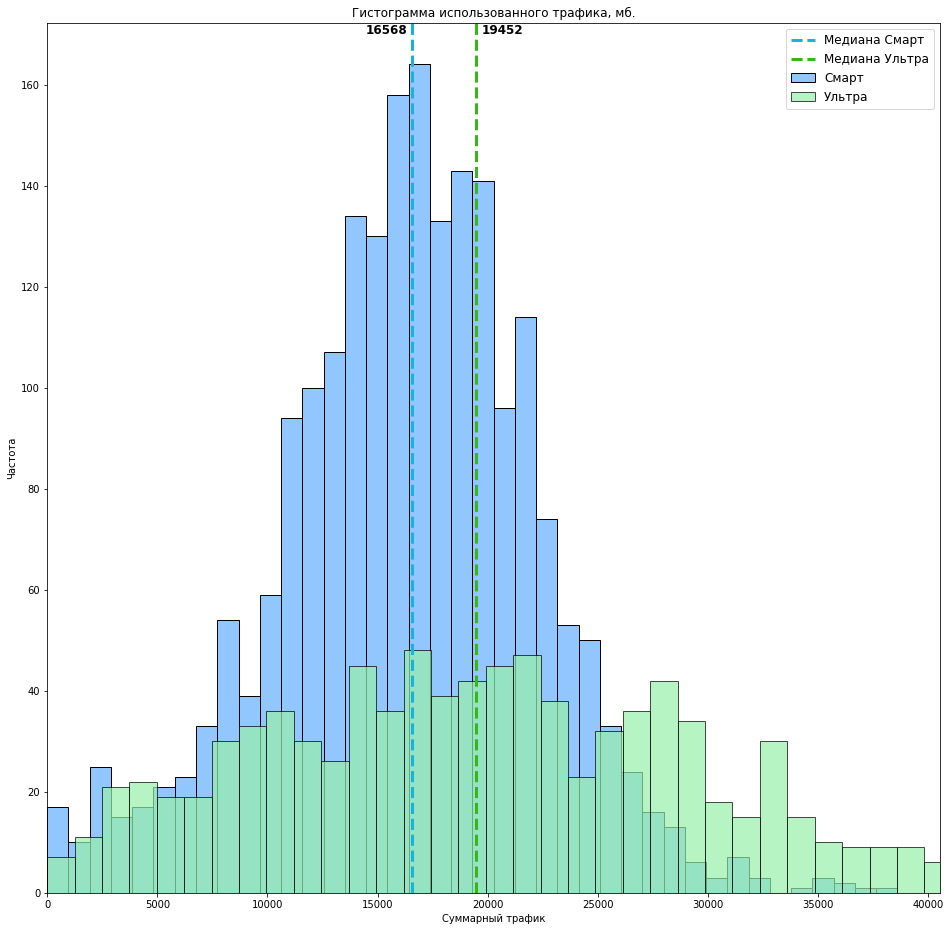

In [76]:
ax = plt.gca() # создаем пустой график
column = 'mb_used' # данные какого столбца будем рисовать
title = 'Гистограмма использованного трафика, мб.' # заголовок
df_all_information[df_all_information['tariff'] == 'smart'][column].plot(kind='hist', bins=40, figsize=(16,16), 
                                                                    ec='black', ax=ax, color='#92c6ff', 
                                                                    title=title, xlim=0) # рисуем 1-й график
df_all_information[df_all_information['tariff'] == 'ultra'][column].plot(kind='hist', bins=40, figsize=(16,16), 
                                                                    ec='black', ax=ax, color='#97F0AA', 
                                                                    title=title, xlim=0, alpha=0.7) # рисуем 2-й график 
plt.axvline(x=df_all_information[df_all_information['tariff'] == 'smart'][column].median(),
            linewidth=3, color='#16B4DC', linestyle='--') # рисуем медианы (сама линия, потом подпись)
ax.text(df_all_information[df_all_information['tariff'] == 'smart'][column].median()-2100, 170, 
        '{0:.0f}'.format(df_all_information[df_all_information['tariff'] == 'smart'][column].median()), 
        fontweight='bold', fontsize='large')
plt.axvline(x=df_all_information[df_all_information['tariff'] == 'ultra'][column].median(),
            linewidth=3, color='#35B815', linestyle='--') # рисуем медианы (сама линия, потом подпись)
ax.text(df_all_information[df_all_information['tariff'] == 'ultra'][column].median()+300, 170, 
        '{0:.0f}'.format(df_all_information[df_all_information['tariff'] == 'ultra'][column].median()), 
        fontweight='bold', fontsize='large')
plt.legend(['Медиана Смарт', 'Медиана Ультра', 'Смарт', 'Ультра'], prop={'size':12}) # рисуем легенду (содержание и размер шрифта)
ax.set_ylabel('Частота')
ax.set_xlabel('Суммарный трафик')

In [77]:
column = 'mb_used'
variance = np.var(df_all_information[df_all_information['tariff'] == 'smart'][column], ddof=1) # считаем дисперсию
standard_deviation = np.std(df_all_information[df_all_information['tariff'] == 'smart'][column], ddof=1) # считаем стандартное отклоение
print ('Среднее значение тарифа смарт равно:', df_all_information[df_all_information['tariff'] == 'smart'][column].mean().astype('int')) # считаем среднее
print ('Стандартное отклонение тарифа смарт равно:', standard_deviation.astype('int')) 
print ('Дисперсия тарифа смарт равна:', variance.astype('int'))
print()
variance = np.var(df_all_information[df_all_information['tariff'] == 'ultra'][column], ddof=1) # считаем дисперсию
standard_deviation = np.std(df_all_information[df_all_information['tariff'] == 'ultra'][column], ddof=1) # считаем стандартное отклоение
print ('Среднее значение тарифа ультра равно:', df_all_information[df_all_information['tariff'] == 'ultra'][column].mean().astype('int')) # считаем среднее
print ('Стандартное отклонение тарифа ультра равно:', standard_deviation.astype('int')) 
print ('Дисперсия тарифа ультра равна:', variance.astype('int'))

Среднее значение тарифа смарт равно: 16302
Стандартное отклонение тарифа смарт равно: 5833
Дисперсия тарифа смарт равна: 34029900

Среднее значение тарифа ультра равно: 19804
Стандартное отклонение тарифа ультра равно: 9844
Дисперсия тарифа ультра равна: 96911895


Исходя из проведенного анализа, можно сделать следующие выводы: пользователи тарифа ультра совершают более длительные звонки, а пользователи тарифа смарт совершают частые более короткие звонки; точно так же как и количество отправленных смс-сообщений и использованного трафика: пользователи ультра отправляют больше сообщений и используют больше трафика, однако средние и медианные значения пользователей тарифа смарт почти совпадают, разброс меньше, что говорит о том, что пользователи смарт в большинстве своем используют одинаковое количество звонков, сообщений и трафика. Распределения по звонкам и трафику тяготеют к нормальному, а по сообщениям ближе к пуассоновскому.

# Проверка гипотез

In [78]:
df_all_information[df_all_information['tariff'] == 'ultra']['total_income']
alpha = .05 # критический уровень статистической значимости    
results = st.ttest_ind(
    df_all_information[df_all_information['tariff'] == 'smart']['total_income'], 
   df_all_information[df_all_information['tariff'] == 'ultra']['total_income'], equal_var = False)   
print('p-значение: ', results.pvalue)   
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.971573005431329e-273
Отвергаем нулевую гипотезу


In [86]:
def mean_confidence_interval(data, confidence=0.95): # функция для расчета доверительного интервала
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m, m+h

In [87]:
mean_confidence_interval(df_all_information[df_all_information['tariff'] == 'smart']['total_income']) # строим доверительный интервал

(1209.1690712937002, 1242.906043437205, 1276.6430155807097)

In [88]:
mean_confidence_interval(df_all_information[df_all_information['tariff'] == 'ultra']['total_income']) # строим доверительный интервал

(2034.6613692816948, 2057.3784378437845, 2080.0955064058744)

In [89]:
alpha = .05 # критический уровень статистической значимости    
results = st.ttest_ind(
     df_all_information[df_all_information['city'] != 'Москва']['total_income'], 
    df_all_information[df_all_information['city'] == 'Москва']['total_income'], equal_var = False)   
print('p-значение: ', results.pvalue)   
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5266744661806044
Не получилось отвергнуть нулевую гипотезу


In [90]:
mean_confidence_interval(df_all_information[df_all_information['city'] != 'Москва']['total_income']) # строим доверительный интервал

(1451.91151559447, 1483.3422873422874, 1514.7730590901047)

In [91]:
mean_confidence_interval(df_all_information[df_all_information['city'] == 'Москва']['total_income']) # строим доверительный интервал

(1444.7469747897749, 1505.3684210526317, 1565.9898673154885)

Итак, первая H0 гипотеза: средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова. Альтернативаня гипотеза: нет, они различаются. Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind. После проведения теста нулевая гипотеза не подтвердилась. Вторая H0 гипотеза: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Альтернативаня гипотеза: нет, не равна. После проведения теста нулевая гипотеза подтвердилась. 

# Общий вывод

По итогам работы было выявлено следующее: пользователи тарифа ультра совершают более длительные звонки, а пользователи тарифа смарт совершают частые более короткие звонки; точно так же как и количество отправленных смс-сообщений и использованного трафика: пользователи ультра отправляют больше сообщений и используют больше трафика, однако средние и медианные значения пользователей тарифа смарт почти совпадают, разброс меньше, что говорит о том, что пользователи смарт в большинстве своем используют одинаковое количество звонков, сообщений и трафика. Распределения по звонкам и трафику тяготеют к нормальному, а по сообщениям ближе к пуассоновскому. 
Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, был применен метод scipy.stats.ttest_ind. После проведения теста гипотеза "Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов" подтвердилась, а вот гипотезу "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается" оказалась неверной.